In [1]:
cd ../../

/mnt/sda/otani/Experiments/moment_retrieval


In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.toolbox.eval import _tiou
from src.toolbox.data_converters import ActivityNetCap2Instances
import json
import os
import pickle as pkl
import seaborn as sns

In [3]:
activitynet_groundtruth = ActivityNetCap2Instances(json.load(open("data/raw/ActivityNet/val_2.json")))

In [12]:
datas = []
data_root = "data/raw/AMT/activitynet/"
for file in os.listdir(data_root):
    if file.split(".")[-1] != "csv":
        continue
    print(data_root+file)
    data = pd.read_csv(data_root+file)
    if "Answer.error_report" in data.columns:
        invalid_hits = data[data["Answer.error_report"] == "video disabled"]["HITId"].unique()
        data = data[~data["HITId"].isin(invalid_hits)]
    datas.append(data[['HITId', 'WorkerId', 'Input.video_id', 'Input.start_sec', 'Input.end_sec', 'Input.length', 'Input.description', 'Answer.end', 'Answer.start']])
data = pd.concat(datas)
print(len(data))

data/raw/AMT/activitynet/Batch_3997812_batch_results.csv
data/raw/AMT/activitynet/Batch_3996080_batch_results.csv
data/raw/AMT/activitynet/Batch_3996408_batch_results.csv
data/raw/AMT/activitynet/Batch_4001034_batch_results.csv
4955


# Examples

In [46]:
hit_id = data.sample()['HITId'].values[0]
data[data['HITId']==hit_id]

,HITId,WorkerId,Input.video_id,Input.start_sec,Input.end_sec,Input.length,Input.description,Answer.end,Answer.start
355,3XBYQ44Z7TLSEJK16H5RYJ8V0PRTWD,A1NH9LK567B862,NjzUWVoc8rw,0.0,6.88125,7.34,a man is standing on a tennis court.,46,27
356,3XBYQ44Z7TLSEJK16H5RYJ8V0PRTWD,A16U1L4R6WV5G2,NjzUWVoc8rw,0.0,6.88125,7.34,a man is standing on a tennis court.,54,0
357,3XBYQ44Z7TLSEJK16H5RYJ8V0PRTWD,A3FTE56VNPQ95C,NjzUWVoc8rw,0.0,6.88125,7.34,a man is standing on a tennis court.,100,0
358,3XBYQ44Z7TLSEJK16H5RYJ8V0PRTWD,A1FGSZ042NZ694,NjzUWVoc8rw,0.0,6.88125,7.34,a man is standing on a tennis court.,40,0
359,3XBYQ44Z7TLSEJK16H5RYJ8V0PRTWD,A1AYL5V5GI9HC1,NjzUWVoc8rw,0.0,6.88125,7.34,a man is standing on a tennis court.,47,0


In [41]:
from scipy.spatial.distance import pdist, squareform
import string
translator = str.maketrans('', '', string.punctuation+' ')

pair_iou = lambda u, v: _tiou(u[None, :], v)

def convertAMTdata2result():
    for _, x in data.groupby("HITId"):
        st_perc = x["Answer.start"]
        ed_perc = x["Answer.end"]
        pred = np.vstack([st_perc, ed_perc]).T
        ious = squareform(pdist(pred, pair_iou))
        ious = ious[~np.eye(ious.shape[0],dtype=bool)].reshape(len(ious), -1)
        index = np.argmax(np.mean(ious, axis=1))
        pred = pred[index]

        video_id = "v_" + x.iloc[0]["Input.video_id"]
        description = x.iloc[0]["Input.description"]
        description = description.translate(translator)
        for gt_instance in activitynet_groundtruth:
            gt_video_id, gt_description = gt_instance[0]
            gt_description = gt_description.translate(translator)
            if gt_video_id == video_id:
                if gt_description == description:
                    st_sec, ed_sec, length = gt_instance[1]
                    break
        pred = pred / 100 * length
        iou_val = _tiou(pred[None, :], (st_sec, ed_sec))
        res = {'R@1 IoU>0.5': iou_val[0]>.5}
        yield (gt_instance[0], [pred.tolist()+[length]], [1], res)

def compute_iou_at_k(x, k=[0, 1, 2, 3, 4]):
    st_perc = x["Answer.start"]
    ed_perc = x["Answer.end"]
    video_id = "v_" + x.iloc[0]["Input.video_id"]
    description = x.iloc[0]["Input.description"]
    description = description.translate(translator)
    for gt_instance in activitynet_groundtruth:
        gt_video_id, gt_description = gt_instance[0]
        gt_description = gt_description.translate(translator)
        if gt_video_id == video_id:
            if gt_description == description:
                st_sec, ed_sec, length = gt_instance[1]
                break    
    pred = np.vstack([st_perc, ed_perc]).T / 100 * length
    ious = _tiou(pred, (st_sec, ed_sec))
    ious = ious[np.argsort(ious)[::-1][k]]
    return ious

def compute_agreement(x):
    st_perc = x["Answer.start"]
    ed_perc = x["Answer.end"]
    pred = np.vstack([st_perc, ed_perc]).T  / 100
    ious = squareform(pdist(pred, pair_iou))
    ious = ious[~np.eye(ious.shape[0],dtype=bool)].reshape(len(ious), -1)
    min_ious = ious.min()
    return min_ious

def compute_iou_with_representative(x):
    st_perc = x["Answer.start"]
    ed_perc = x["Answer.end"]
    pred = np.vstack([st_perc, ed_perc]).T  / 100
    ious = squareform(pdist(pred, pair_iou))
    ious = ious[~np.eye(ious.shape[0],dtype=bool)].reshape(len(ious), -1)
    index = np.argmax(np.mean(ious, axis=1))
    pred = pred[index]
    
    video_id = "v_" + x.iloc[0]["Input.video_id"]
    description = x.iloc[0]["Input.description"]
    description = description.translate(translator)
    for gt_instance in activitynet_groundtruth:
        gt_video_id, gt_description = gt_instance[0]
        gt_description = gt_description.translate(translator)
        if gt_video_id == video_id:
            if gt_description == description:
                st_sec, ed_sec, length = gt_instance[1]
                break
    ious = _tiou(pred[None,:]*length, (st_sec, ed_sec))
    return ious

In [39]:
predictions = list(convertAMTdata2result())
pkl.dump(predictions, open("reports/outputs/performance/activitynet/representative_human.pkl", "wb"))

# Agreement

Text(0.5, 1.0, 'Median min IoU: 0.06')

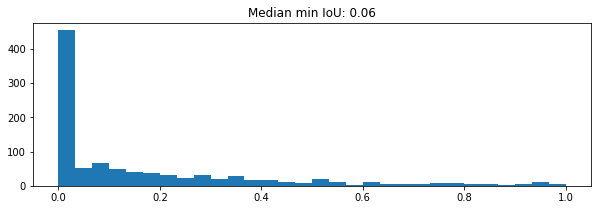

In [8]:
agreement = data.groupby("HITId").apply(compute_agreement).values
plt.figure(figsize=(10, 3))
plt.hist(agreement, bins=30)
plt.title(f"Median min IoU: {np.median(agreement):.2f}")

# IoUs of best human annotation

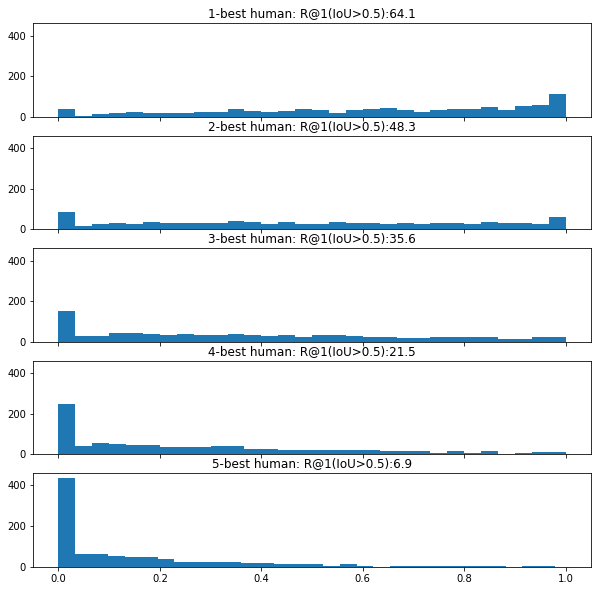

In [9]:
f, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True, sharey=True)
for ax, k in zip(axes, [0,1,2,3,4]):
    human_ious = data.groupby("HITId").apply(lambda x: compute_iou_at_k(x, k=[k]))
    human_ious = np.hstack(human_ious.values)
    ax.hist(human_ious, bins=30)
    ax.set_title(f"{k+1}-best human: "+f"R@1(IoU>0.5):{np.mean(human_ious > .5)*100:.1f}")

# Performance of Representative Human annotation

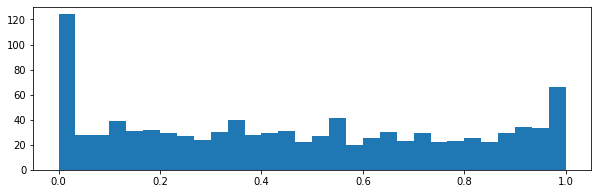

R@1(IoU>0.5):45.3


In [10]:
human_ious = data.groupby("HITId").apply(compute_iou_with_representative).values
plt.figure(figsize=(10, 3))
plt.hist(np.hstack(human_ious), bins=30)
plt.show()
print(f"R@1(IoU>0.5):{np.mean(np.hstack(human_ious) > .5)*100:.1f}")

In [105]:
med_human = human_ious.apply(np.median)
failures = med_human[med_human < 0.5]

In [209]:
data[data["WorkerId"]=="A3N5P5VO81FIJ6"]["HITId"].sample().values[0]

'3OREP8RUU6SWLB0KRQAOCMGL0Q0BGX'

- 3WJGKMRWWMQCJWIZ305BHLJ65O4DCQ

In [197]:
hitid = data["HITId"].sample().values[0]
sample_data = data[data["HITId"] == hitid][["Input.video_id","Answer.start", "Answer.end", "Input.description", "Input.start_sec", "Input.end_sec", "WorkerId"]]
video_id = sample_data["Input.video_id"].values[0]
description = sample_data["Input.description"].values[0]
pred_st = sample_data["Input.start_sec"].values[0]
pred_ed = sample_data["Input.end_sec"].values[0]
for gt_instance in activitynet_groundtruth:
    if gt_instance[0] == ("v_"+video_id, description):
        st_sec, ed_sec, length = gt_instance[1]
print(st_sec, ed_sec)
sample_data

59.55 105.4


,Input.video_id,Answer.start,Answer.end,Input.description,Input.start_sec,Input.end_sec,WorkerId
1460,YiBenqCKGcA,0,12,a woman is doing somer saults and big jumps a...,0.0,98.8125,A1NH9LK567B862
1461,YiBenqCKGcA,0,8,a woman is doing somer saults and big jumps a...,0.0,98.8125,A16U1L4R6WV5G2
1462,YiBenqCKGcA,0,41,a woman is doing somer saults and big jumps a...,0.0,98.8125,A1NJ6Q940T7HEB
1463,YiBenqCKGcA,32,43,a woman is doing somer saults and big jumps a...,0.0,98.8125,A272A0JGRTBFCR
1464,YiBenqCKGcA,0,8,a woman is doing somer saults and big jumps a...,0.0,98.8125,AVPD36WUJKJFS


 a woman is doing somer saults and big jumps alone.


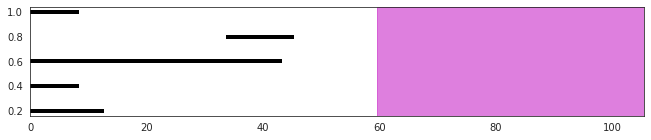

In [198]:
from IPython.display import Video, HTML
print(description)
f = plt.figure(figsize=(11, 2))
plt.axvspan(st_sec, ed_sec, color="m", alpha=0.5)
# plt.axvspan(pred_st, pred_ed, color="g", alpha=0.5)
plt.xlim([0, length])
# plt.yticks([0.2, 0.4, 0.6, 0.8, 1.], [f"annotator {i+1}" for i in range(5)])

y = 0.2
for _, row in sample_data.iterrows():
    plt.hlines(y, row["Answer.start"] * length/100, row["Answer.end"]*length/100, linewidth=4)
    y += 0.2

HTML(f"""
     <iframe id="ytplayer" type="text/html" width="640" height="360"
  src="https://www.youtube.com/embed/{video_id}"
  frameborder="0"></iframe>
     """)

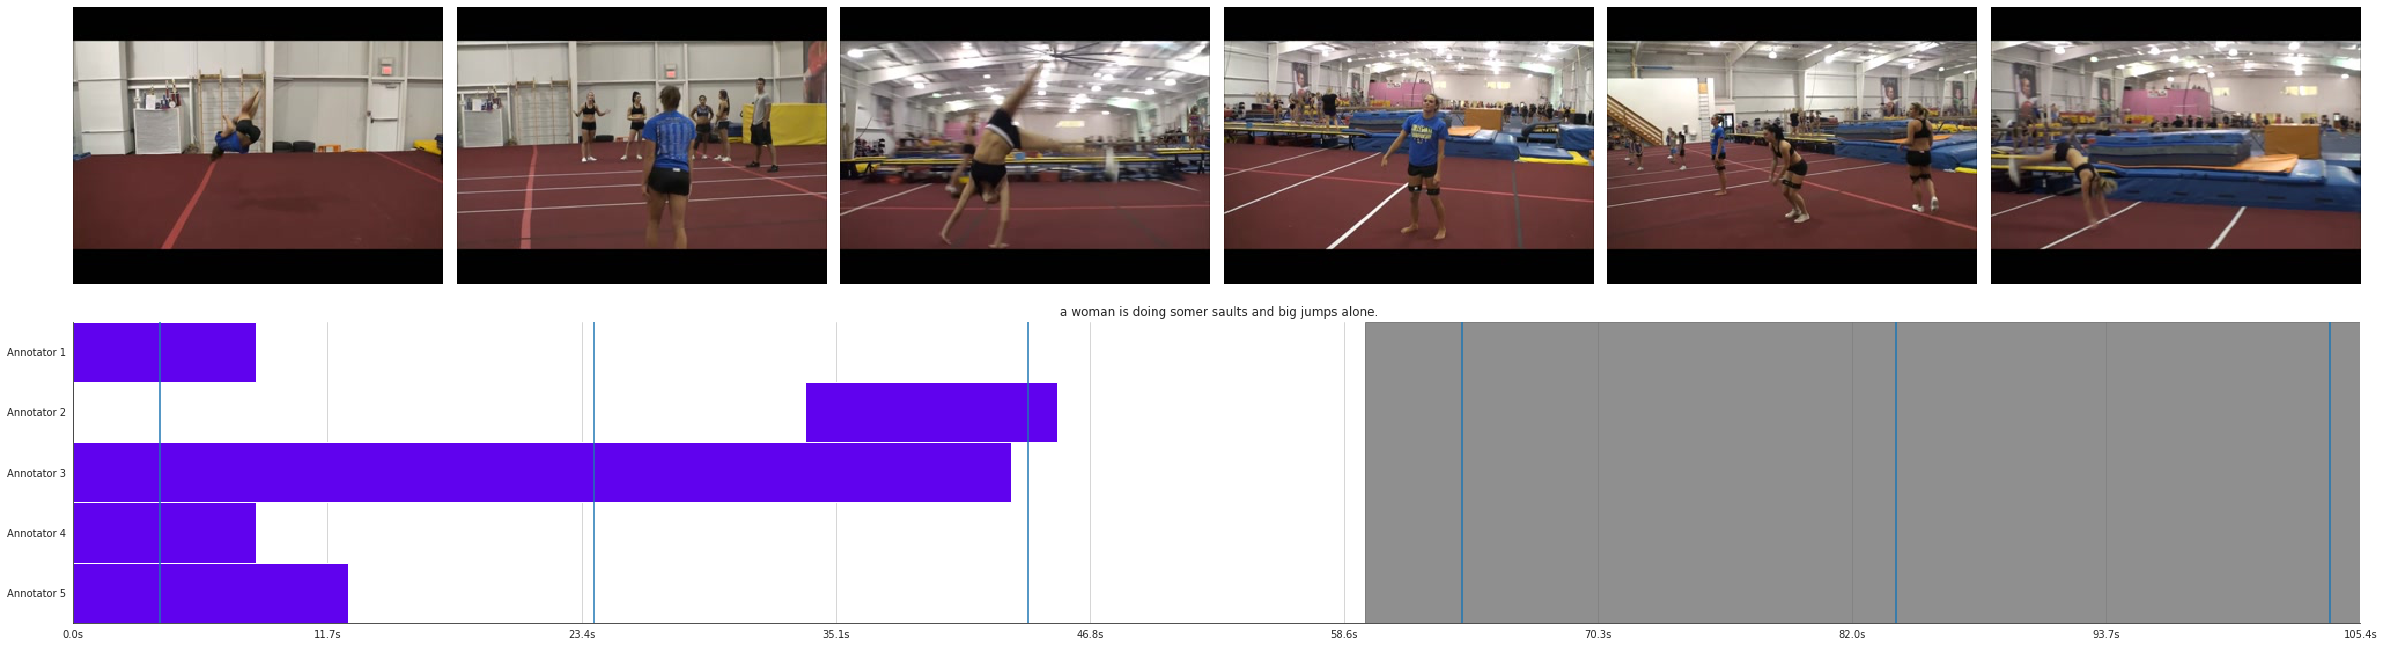

In [211]:
sns.set_style("white")
f = plt.figure(figsize=(11*3, 3*3), constrained_layout=True)

gs = f.add_gridspec(2, 6)

frame_dir = f'/home/otani_mayu/3TDisk/Data/ActivityNetCap/activitynet_frames/v_{video_id}/'
n_frame = len(os.listdir(frame_dir))
sample_sec = np.linspace(4, int(length)-1, 6).astype("i")
frames = [f'{frame_dir}{int(n_frame / length * sec):0>6}.jpg' for sec in sample_sec]

for i, frame in enumerate(frames):
    img_ax = f.add_subplot(gs[0, i])
    im = plt.imread(frame)
    img_ax.imshow(im)
    img_ax.axis("off")

ax_timeline= f.add_subplot(gs[1, :])

ax_timeline.axvspan(st_sec, ed_sec, color="#606060", alpha=0.7)
# plt.axvspan(pred_st, pred_ed, color="g", alpha=0.5)
ax_timeline.set_xlim([0, length])
# plt.yticks([0.2, 0.4, 0.6, 0.8, 1.], [f"annotator {i+1}" for i in range(5)])

y = 0
for _, row in sample_data.iterrows():
    ax_timeline.axvspan(row["Answer.start"] * length/100,
                row["Answer.end"]*length/100,
               y,y+0.2,
               facecolor='#6002ee',
               )
    y += 0.2

for s in sample_sec:
    ax_timeline.axvline(s)
    
ax_timeline.set_xticks(np.linspace(0, length, 10))
ax_timeline.set_xticklabels([f'{s:.1f}s' for s in np.linspace(0, length, 10)])
ax_timeline.set_yticks(np.linspace(0.1, 0.9, 5))
ax_timeline.set_yticklabels([f'Annotator {a_id}' for a_id in [5,4,3,2,1]])
ax_timeline.xaxis.grid()
sns.despine()
plt.title(description)
plt.savefig(f'reports/figures/human_annotation/{video_id}.pdf',
           bbox_inches='tight')

In [185]:
data[data["WorkerId"] == "A2CKYCHQGXUI10"]

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,Last7DaysApprovalRate,Input.video_url,Input.start_sec,Input.end_sec,Input.length,Input.description,Answer.end,Answer.start,Approve,Reject
160,3OEWW2KGRNSDSLF2T5E2CLDNUX3DOT,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:08 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),QUXYH.mp4,19.087502,30.540001,30.54,person seems to be laughing into the blanket.,26,0,NaN,NaN
302,3TZ0XG8CCY1Y43F5A8K4T34XO7K894,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:09 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),HG7C2.mp4,0.000000,9.309376,29.79,a person is undressing in the doorway.,49,0,NaN,NaN
477,38Z7YZ2SC7JXL8840W7HSNO013TIQ8,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:09 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),QWKVM.mp4,5.773125,15.395000,30.79,person puts a glass on the desk.,23,10,NaN,NaN
515,3AA88CN99TKX05PER99NIP6FSGZKYO,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:10 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),IOGR7.mp4,13.291249,22.785000,30.38,person they stand up.,100,74,NaN,NaN
605,30U1YOGZHEDSQD7V0MVBWQNORM6DSQ,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:10 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),Z3H4P.mp4,0.000000,7.510000,30.04,person puts some food on a plate.,100,54,NaN,NaN
660,3TRB893CTNR9JZXUE9Y87KUPH09G7G,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:19 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),TK1VC.mp4,12.631249,20.209999,20.21,person starts sneezing.,35,3,NaN,NaN
813,3TD33TP5EPJVBKNH5QIEG05I2VNBAL,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:19 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),9POJB.mp4,23.535000,31.379999,31.38,person stand up.,100,86,NaN,NaN
894,3S829FDFU6I0MUTUUW1YVY4G618DXY,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:11 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),TEV5K.mp4,0.000000,9.556250,30.58,a person opens the window.,21,0,NaN,NaN
895,335VBRURENHFD4PWNB64LD0JZAIE99,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:20 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),MKMFK.mp4,0.000000,7.084375,22.67,person drinking out of a cup.,20,0,NaN,NaN
918,3J9UN9O9K795SQNB1GY2PICI1EKJ0N,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:11 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),E6DLK.mp4,0.000000,8.515625,27.25,a person sits on a chair.,42,0,NaN,NaN
